In [114]:
import os
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import SimpleITK as itk

class LV_Dataset:
    
    def __init__(self,
                 dataset_path='/home/vasily/datasets/us_camus/', 
#                  subset='train',
                 random_state=17, 
#                  test_size=0.2, 
                 folds=9,
#                  lv_crop_ratio=1.2, 
#                  lv_crop_aspect_ratio=.5,
                ):
        # Initalized all variables.       
        
        np.random.seed(random_state)
        self.dataset_path = os.path.join(dataset_path, 'training')
                
        if folds:
            self.folds = max(0, folds)
        else:
            self.folds = None
        
        self.get_patient_info()
        self.calc_info()
    
    def get_patient_info(self):
        ends = [
            '_2CH_ED.mhd', '_2CH_ED_gt.mhd', '_2CH_ES.mhd', '_2CH_ES_gt.mhd', '_4CH_ED.mhd', '_4CH_ED_gt.mhd', '_4CH_ES.mhd', '_4CH_ES_gt.mhd',
            '_2CH_ED.raw', '_2CH_ED_gt.raw', '_2CH_ES.raw', '_2CH_ES_gt.raw', '_4CH_ED.raw', '_4CH_ED_gt.raw', '_4CH_ES.raw', '_4CH_ES_gt.raw',
               ]
        
        self.df_images = pd.DataFrame(columns=['patient', 'heart_state', 'view', 'quality', 'img_shape', 'img_names', 'msk_names'])
        self.df_patients = pd.DataFrame(columns=['patient', 'ef', 'quality'])
        
        for patient in np.sort(os.listdir(self.dataset_path)):
            patient_files = os.listdir(os.path.join(self.dataset_path, patient))
            if not patient_files:
                continue

            for file in [patient + it for it in ends]:
                if file not in patient_files:
                    print('There is no file in folder of ' + patient)
                    return
             
            if 'Info_2CH.cfg' not in patient_files or 'Info_4CH.cfg' not in patient_files:
                print('There is no cfg file in folder of ' + patient)
                return
                    
            #  Read cfg 2CH
            f = open(os.path.join(self.dataset_path, patient, 'Info_2CH.cfg'))
            for it in f.readlines():
                if it.startswith('ImageQuality'):
                    quality_2ch = it.split()[-1]
                elif it.startswith('LVef'):
                    ef_2ch = it.split()[-1]
            
            #  Read cfg 4CH
            f = open(os.path.join(self.dataset_path, patient, 'Info_4CH.cfg'))
            for it in f.readlines():
                if it.startswith('ImageQuality'):
                    quality_4ch = it.split()[-1]
                elif it.startswith('LVef'):
                    ef_4ch = it.split()[-1]
            
            if quality_2ch == 'Poor' or quality_4ch == 'Poor':
                pat_quality = 'Poor'
            elif quality_2ch == 'Medium' or quality_4ch == 'Medium':
                pat_quality = 'Medium'
            elif quality_2ch == 'Good' or quality_4ch == 'Good':
                pat_quality = 'Good'
            
            if ef_2ch != ef_4ch:
                print('Problems with EF')
            
            self.df_patients = self.df_patients.append({'patient' : patient, 
                                                        'quality' : pat_quality,
                                                        'ef': float(ef_2ch),
                                                       }, ignore_index=True)
            
            
                                                       
            img_shapes = []
            f = open(os.path.join(self.dataset_path, patient, patient + '_2CH_ED.mhd'))
            img_shapes.append(tuple(map(int, sum([it.split()[-3:-1] for it in f.readlines() if it.startswith('DimSize')], []))))
            f = open(os.path.join(self.dataset_path, patient, patient + '_2CH_ES.mhd'))
            img_shapes.append(tuple(map(int, sum([it.split()[-3:-1] for it in f.readlines() if it.startswith('DimSize')], []))))
            f = open(os.path.join(self.dataset_path, patient, patient + '_4CH_ED.mhd'))
            img_shapes.append(tuple(map(int, sum([it.split()[-3:-1] for it in f.readlines() if it.startswith('DimSize')], []))))
            f = open(os.path.join(self.dataset_path, patient, patient + '_4CH_ES.mhd'))
            img_shapes.append(tuple(map(int, sum([it.split()[-3:-1] for it in f.readlines() if it.startswith('DimSize')], []))))
                                 
            
            self.df_images = self.df_images.append({'patient' : [patient, patient, patient, patient],
                                                    'heart_state' : ['ED', 'ES', 'ED', 'ES'],
                                                    'view' : ['2CH', '2CH', '4CH', '4CH'],
                                                    'quality' : [ef_2ch, ef_4ch, ef_2ch, ef_4ch],
                                                    'img_shape' : img_shapes,
                                                    'img_names' : [patient + it for it in ['_2CH_ED.mhd', '_2CH_ES.mhd', '_4CH_ED.mhd', '_4CH_ES.mhd']],
                                                    'msk_names' : [patient + it for it in ['_2CH_ED_gt.mhd', '_2CH_ES_gt.mhd', '_4CH_ED_gt.mhd', '_4CH_ES_gt.mhd']],
                                                   }, ignore_index=True)
        
        if self.folds:
            self.df_patients['fold'] = None
            self.num_patient_in_fold = self.df_patients['quality'].value_counts() / self.folds
            for fold in range(self.folds):
                count = {'Good':0, 'Medium':0, 'Poor':0}
                for index, row in self.df_patients.iterrows():
                    if not pd.isna(row['fold']):
                        continue
                    quality = row['quality']
                    if count[quality] < self.num_patient_in_fold[quality]:
                        count[quality] += 1
                        self.df_patients['fold'].at[index] = fold
                    if sum(list(count.values())) == 50:
                        break
    
    
    def calc_info(self):
        
        self.ef_dist = {'<=45': 0, '>=55': 0, 'else': 0}
        self.ef_dist['<=45'] = len(self.df_patients[(self.df_patients['ef'] <= 45)]) / len(self.df_patients)
        self.ef_dist['>=55'] = len(self.df_patients[(self.df_patients['ef'] >= 55)]) / len(self.df_patients)
        self.ef_dist['else'] = len(self.df_patients[(self.df_patients['ef'] > 45) & (self.df_patients['ef'] < 55)]) / len(self.df_patients)
        
        self.quality_dist = dict(self.df_patients['quality'].value_counts() / len(self.df_patients))
        
        self.ef_fold_dist = {}
        for fold in range(self.folds):
            self.ef_fold_dist[fold] = {'<=45': 0, '>=55': 0, 'else': 0}
            self.ef_fold_dist[fold]['<=45'] = len(self.df_patients[(self.df_patients['fold'] == fold) & (self.df_patients['ef'] <= 45)]) / len(self.df_patients) * self.folds
            self.ef_fold_dist[fold]['>=55'] = len(self.df_patients[(self.df_patients['fold'] == fold) & (self.df_patients['ef'] >= 55)]) / len(self.df_patients) * self.folds
            self.ef_fold_dist[fold]['else'] = len(self.df_patients[(self.df_patients['fold'] == fold) & (self.df_patients['ef'] > 45) & (self.df_patients['ef'] < 55)]) / len(self.df_patients) * self.folds
           
        for fold in range(self.folds):
            self.quality_fold_dist = dict(self.df_patients[self.df_patients['fold'] == fold]['quality'].value_counts() / len(self.df_patients) * self.folds)

In [115]:
lv = LV_Dataset()

In [116]:
lv.df_images

,patient,heart_state,view,quality,img_shape,img_names,msk_names
0,"[patient0001, patient0001, patient0001, patien...","[ED, ES, ED, ES]","[2CH, 2CH, 4CH, 4CH]","[63.2, 63.2, 63.2, 63.2]","[(549, 778), (549, 778), (549, 778), (549, 778)]","[patient0001_2CH_ED.mhd, patient0001_2CH_ES.mh...","[patient0001_2CH_ED_gt.mhd, patient0001_2CH_ES..."
1,"[patient0002, patient0002, patient0002, patien...","[ED, ES, ED, ES]","[2CH, 2CH, 4CH, 4CH]","[49.4, 49.4, 49.4, 49.4]","[(748, 1167), (748, 1167), (748, 1167), (748, ...","[patient0002_2CH_ED.mhd, patient0002_2CH_ES.mh...","[patient0002_2CH_ED_gt.mhd, patient0002_2CH_ES..."
2,"[patient0003, patient0003, patient0003, patien...","[ED, ES, ED, ES]","[2CH, 2CH, 4CH, 4CH]","[55.4, 55.4, 55.4, 55.4]","[(591, 973), (591, 973), (591, 973), (591, 973)]","[patient0003_2CH_ED.mhd, patient0003_2CH_ES.mh...","[patient0003_2CH_ED_gt.mhd, patient0003_2CH_ES..."
3,"[patient0004, patient0004, patient0004, patien...","[ED, ES, ED, ES]","[2CH, 2CH, 4CH, 4CH]","[62.1, 62.1, 62.1, 62.1]","[(641, 908), (641, 908), (641, 908), (641, 908)]","[patient0004_2CH_ED.mhd, patient0004_2CH_ES.mh...","[patient0004_2CH_ED_gt.mhd, patient0004_2CH_ES..."
4,"[patient0005, patient0005, patient0005, patien...","[ED, ES, ED, ES]","[2CH, 2CH, 4CH, 4CH]","[53.4, 53.4, 53.4, 53.4]","[(591, 973), (591, 973), (591, 973), (591, 973)]","[patient0005_2CH_ED.mhd, patient0005_2CH_ES.mh...","[patient0005_2CH_ED_gt.mhd, patient0005_2CH_ES..."
...,...,...,...,...,...,...,...
445,"[patient0446, patient0446, patient0446, patien...","[ED, ES, ED, ES]","[2CH, 2CH, 4CH, 4CH]","[30.9, 30.9, 30.9, 30.9]","[(630, 1038), (630, 1038), (708, 1168), (708, ...","[patient0446_2CH_ED.mhd, patient0446_2CH_ES.mh...","[patient0446_2CH_ED_gt.mhd, patient0446_2CH_ES..."
446,"[patient0447, patient0447, patient0447, patien...","[ED, ES, ED, ES]","[2CH, 2CH, 4CH, 4CH]","[33.8, 33.8, 33.8, 33.8]","[(394, 649), (394, 649), (394, 649), (394, 649)]","[patient0447_2CH_ED.mhd, patient0447_2CH_ES.mh...","[patient0447_2CH_ED_gt.mhd, patient0447_2CH_ES..."
447,"[patient0448, patient0448, patient0448, patien...","[ED, ES, ED, ES]","[2CH, 2CH, 4CH, 4CH]","[61.0, 61.0, 61.0, 61.0]","[(512, 843), (512, 843), (512, 843), (512, 843)]","[patient0448_2CH_ED.mhd, patient0448_2CH_ES.mh...","[patient0448_2CH_ED_gt.mhd, patient0448_2CH_ES..."
448,"[patient0449, patient0449, patient0449, patien...","[ED, ES, ED, ES]","[2CH, 2CH, 4CH, 4CH]","[57.8, 57.8, 57.8, 57.8]","[(445, 779), (445, 779), (433, 714), (433, 714)]","[patient0449_2CH_ED.mhd, patient0449_2CH_ES.mh...","[patient0449_2CH_ED_gt.mhd, patient0449_2CH_ES..."


In [86]:
lv.df_patients

,patient,ef,fold,quality,e
0,patient0001,63.2,0.0,Good,None
1,patient0002,49.4,0.0,Medium,None
2,patient0003,55.4,0.0,Good,None
3,patient0004,62.1,0.0,Medium,None
4,patient0005,53.4,0.0,Medium,None
...,...,...,...,...,...
445,patient0446,30.9,8.0,Poor,None
446,patient0447,33.8,8.0,Poor,None
447,patient0448,61.0,8.0,Poor,None
448,patient0449,57.8,8.0,Poor,None


In [85]:
lv.df_patients['e'] = None

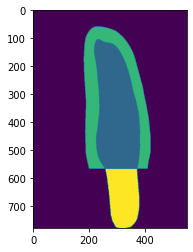

In [14]:
image_itk = itk.ReadImage('../datasets/us_camus/training/patient0001/patient0001_2CH_ED_gt.mhd')
img = itk.GetArrayFromImage(image_itk)
plt.imshow(np.squeeze(img))
# plt.imshow(np.squeeze(io.imread('../datasets/us_camus/training/patient0001/patient0001_2CH_ED_gt.mhd', plugin='simpleitk')))

In [19]:
config = configparser.ConfigParser()
config.read('../datasets/us_camus/training/patient0001/info_2CH.cfg')

[]

In [15]:
image_itk.GetMetaData('Quality')

RuntimeError: Exception thrown in SimpleITK Image_GetMetaData: /tmp/SimpleITK-build/ITK/Modules/Core/Common/src/itkMetaDataDictionary.cxx:88:
itk::ERROR: Key 'Quality' does not exist 